# Zápočtová úloha do F7270
### Veronika Dočkalová

Naměřené hodnoty signálu detektoru částic v čase budeme fitovat exponenciální funkcí $y=A\exp(−t\lambda)$. Pro účely lineární regrese provedeme logaritmickou transformaci naměřených dat i fitované funkce $\ln(y)=\ln(A)-t\lambda$ a budeme hledat hodnoty parametrů $\ln(A)$ a $\lambda$.

Nejdříve naimportujeme všechny potřebné balíčky. Do proměnných x,y uložíme naměřené hodnoty, z nichž ovšem odstraníme všechny nulové body, a spočítáme $\ln(y)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mereni=np.loadtxt("sada_424108_300ks.txt")

In [3]:
pole = []
for x in mereni:
    if x[1] != 0:
        pole.append(x)
pole = np.array(pole)
x,y=data=np.transpose(pole)

In [4]:
ln_y=np.log(y)

Dále vytvoříme sloupcovou modelovou matici M (2 x $n$), jejíž první řádek tvoří jedničky a druhý hodnoty -$x$. Z ní zkonstruujeme Hessián H=M$^{T}$M.

In [5]:
M=np.array([np.ones(len(x)), -x]).T
H=M.T.dot(M)
H

array([[  295.   , -1304.22 ],
       [-1304.22 ,  7717.752]])

Nyní můžeme dosadit do vzorce pro výpočet matice parametrů $\hat{\theta}$=H$^{-1}$M$^T$Y, kde Y je matice (vektor) hodnot $\ln(y)$

In [6]:
H_inv=np.linalg.inv(H)
theta=H_inv.dot(M.T.dot(ln_y))
theta

array([ 4.49739835,  0.47789606])

a spočítat hodnoty parametrů $A$ a $\lambda$

In [7]:
A=np.exp(theta[0])
L=theta[1]
A,L

(89.783242914613467, 0.47789605565604321)

Nakonec vykreslíme data a výslednou fitovanou funkci do grafu

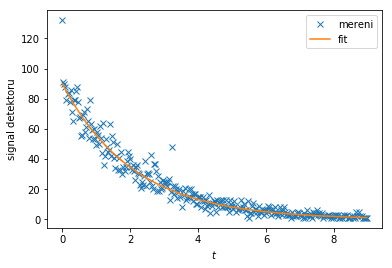

In [8]:
plt.plot(x,y, "x", label="mereni")
plt.plot(x,A*np.exp(-x*L), label="fit")
plt.xlabel("$t$")
plt.ylabel("signal detektoru")
plt.legend(loc=0)

Nejistoty parametrů určíme z kovarianční matice cov($\hat{\theta}$)=$\sigma^2$H$^{-1}$. Odhad hodnoty $\sigma^2$ získáme ze vztahu $\sigma^2=Q^2_{min}/(n-r)$, kde $Q^2_{min}=\Sigma_i(y_{m_i}-y_{f_i})^2$ je suma reziduí v minimu ($y_m$, $y_f$ jsou naměřené hodnoty, resp. hodnoty fitu) a $n-r$ je počet stupňů volnosti, tj. počet hodnot $-$ 2 (parametry).

In [9]:
Q_min=np.sum((ln_y-(theta[0]-x*theta[1]))**2)
Q_min

40.73350142038278

In [10]:
sigma=Q_min/(len(x)-2)
cov_theta=sigma*H_inv
cov_theta

array([[  1.86355937e-03,   3.14922196e-04],
       [  3.14922196e-04,   7.12318841e-05]])

Na diagonále kovarianční matice jsou rozptyly parametrů $\sigma^2(\ln A)$, $\sigma^2(\lambda)$, z nichž po odmocnění dostaneme nejistoty. Mimo diagonálu se nachází člen $\rho\sigma^2(\ln A)\sigma^2(\lambda)$, ze kterého můžeme určit korelační koeficient.

In [11]:
sigma_lnA=np.sqrt(cov_theta[0,0])
sigma_L=np.sqrt(cov_theta[1,1])
corel=cov_theta[0,1]/(sigma_lnA*sigma_L)
sigma_lnA, sigma_L, corel

(0.043168963098006073, 0.0084398983437483921, 0.86435955708784351)

Nejistotu $\sigma(\ln A)$ převedeme pomocí zákona o šíření nejistot na nejistotu, ze kterého je možné odvodit $\sigma(A)=A\sigma(\ln A)$. Finální hodnoty fitovaných parametrů jsou

In [12]:
sigma_A=A*sigma_lnA
print("A = {} +- {}".format(A, sigma_A))
print("L = {} +- {}".format(L, sigma_L))

A = 89.78324291461347 +- 3.875849500200264
L = 0.4778960556560432 +- 0.008439898343748392


Výše uvedený postup je správný pro konstantní hodnoty nejistot měřených bodů. V případě, že každý bod má jinou nejistotu, je nutné do výpočtu zahrnout navíc váhovou matici W, která tuto skutečnost reflektuje. Váhová matice je diagonální matice, jejíž prvky jsou tvořeny převrácenou hodnotou rozptylu jednotlivých naměřených bodů.

### a) Konstantní nejistoty

Jelikož v průběhu zpracování měření provádíme logaritmicku transformaci, budeme muset pracovat s nekonstantními nejistotami i tehdy, když původní data mají nejistotu konstantní. V případě a) platí mezi rozptylem transformaovaných dat a původními hodnotami úměra  $\sigma^2 \approx y^{-2}$. Zkonstruujeme tedy váhovou matici W_a, na jejíž diagonále budou hodnoty $y^2$.

In [13]:
W_a=np.eye(len(x))*(y**2)

Váhovou matici je nutné zahrnout jak do výpočtu Hessiánu H=M$^{T}$WM, tak do výpočtu matice parametrů $\hat{\theta}$=H$^{-1}$M$^T$WY. Abychom nemuseli opisovat celý výše uvedený postup, definujeme si funkci, která provede celou analýzu dat automaticky.

In [14]:
def analyza(data, W, title):
    x=data[0]
    y=data[1]
    ln_y=np.log(y)
    M=np.array([np.ones(len(x)), -x]).T
    H=M.T.dot(W.dot(M))
    H_inv=np.linalg.inv(H)
    theta=H_inv.dot(M.T.dot(W.dot(ln_y)))
    A=np.exp(theta[0])
    L=theta[1]
    Q_min=np.sum((ln_y-(theta[0]-x*theta[1]))**2)
    sigma=Q_min/(len(x)-2)
    cov_theta=sigma*H_inv
    sigma_lnA=np.sqrt(cov_theta[0,0])
    sigma_L=np.sqrt(cov_theta[1,1])
    corel=cov_theta[0,1]/(sigma_lnA*sigma_L)
    sigma_A=A*sigma_lnA
    plt.plot(x,y, "x")
    plt.plot(x,A*np.exp(-x*L), label=title)
    plt.xlabel("$t$")
    plt.ylabel("signal detektoru")
    plt.legend(loc=0)
    print("ln(A) = {} +- {}".format(theta[0], sigma_lnA))
    print("korel.koef. = {}".format(corel))
    print("Q_min= {}".format(Q_min))
    print("A = {} +- {}".format(A, sigma_A))
    print("L = {} +- {}".format(L, sigma_L))
    return A,L

ln(A) = 4.531650623564943 +- 0.0010375505321566893
korel.koef. = 0.6937799893165646
Q_min= 50.12905949567006
A = 92.91179698148564 +- 0.0964006844017747
L = 0.44895602717997285 +- 0.0006814487251427288


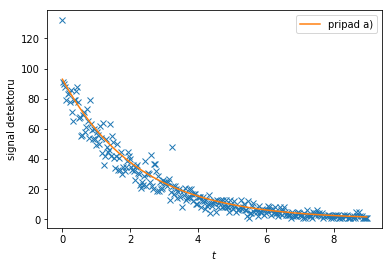

In [15]:
title_a="pripad a)"
a=analyza(data, W_a, title_a) # do proměnné "a" si uložíme hodnoty vektoru theta

Dále získáme rozdělení reziduí

(array([  4.,   2.,  15.,  25.,  85.,  91.,  48.,   9.,   7.,   3.,   1.,
          3.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([-14.36167512, -11.53275351,  -8.7038319 ,  -5.87491029,
         -3.04598868,  -0.21706707,   2.61185454,   5.44077615,
          8.26969776,  11.09861937,  13.92754098,  16.75646259,
         19.5853842 ,  22.41430581,  25.24322742,  28.07214903,
         30.90107064,  33.72999225,  36.55891386,  39.38783547,  42.21675709]),
 <a list of 20 Patch objects>)

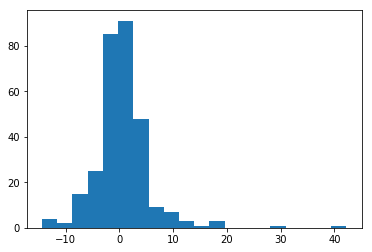

In [16]:
reziduum_a=y-(A*np.exp(-x*L))
plt.hist(reziduum_a, bins=20)

a porovnáním šikmosti (skewness) a špičatosti (kurtosis) otestujeme hypotézu, zda rezidua odpovídají normálně rozděleným datům. Koeficient šikmosti spočítáme pomocí podílu třetího centrálního momentu a třetí mocniny směrodatné odchylky
$$\mathrm{skew}=\frac{\mu_3}{\sigma^3}=\frac{E\left[ (x-\mu)^3 \right]}{\left( E\left[ (x-\mu)^2 \right]\right)^{3/2}}$$
a její nejistotu jako $\sqrt{6/n}$. Koeficient špičatosti je dán vzorcem
$$\mathrm{kurt}=\frac{\mu_4}{\sigma^4}-3=\frac{E\left[ (x-\mu)^4 \right]}{\left( E\left[ (x-\mu)^2 \right]\right)^2}-3$$
s odchylkou $\sqrt{24/n}$

In [17]:
expvalue_a=np.mean(reziduum_a)
CM4_a=np.mean((reziduum_a-expvalue_a)**4)
CM3_a=np.mean((reziduum_a-expvalue_a)**3)
CM2_a=np.mean((reziduum_a-expvalue_a)**2)
skew_a=np.sqrt(CM3_a**2/CM2_a**3)
sigma_skew_a=np.sqrt(6/len(x))
kurt_a=np.sqrt(CM4_a**2/CM2_a**4)-3
sigma_kurt_a=np.sqrt(24/len(x))
print("skew = {} +- {}".format(skew_a, sigma_skew_a))
print("kurt = {} +- {}".format(kurt_a, sigma_kurt_a))
print("2sigma = {} ".format(2*np.sqrt(CM2_a)))
print("3sigma = {} ".format(3*np.sqrt(CM2_a)))

skew = 2.2812664058225205 +- 0.1426148065624585
kurt = 15.183455555907255 +- 0.285229613124917
2sigma = 10.640374915767218 
3sigma = 15.960562373650827 


Vidíme, že šikmost i špičatost se od nuly liší o více než $2\sigma$, tudíž zamítáme nulovou hypotézu, že rezidua mají normální rozdělení. Z měření tedy odděláme odlehlé hodnoty zatížené hrubou chybou, tj. takové, jejichž reziduum se od střední hodnoty reziduí liší o více než $3\sigma$, a postup zopakujeme.

In [18]:
sigma3=3*np.sqrt(CM2_a)
pole_a1 = []
for z in pole:
   if (expvalue_a-sigma3) < (z[1] -(a[0]*np.exp(-z[0]*a[1]))) < expvalue_a+sigma3:
        pole_a1.append(z)
pole_a1 = np.array(pole_a1)
x1,y1=data1=np.transpose(pole_a1)

ln(A) = 4.509360443028548 +- 0.0011298384142490972
korel.koef. = 0.7156923771919719
Q_min= 49.14578134568504
A = 90.86368741869804 +- 0.10266128450596744
L = 0.4448481406870539 +- 0.0007175048418888641


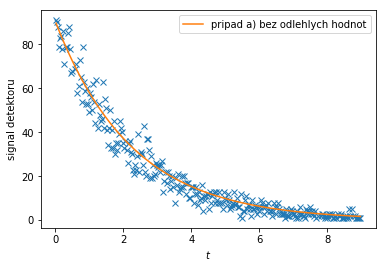

In [19]:
W_a1=np.eye(len(x1))*(y1**2)
title_a1="pripad a) bez odlehlych hodnot"
a1=analyza(data1, W_a1, title_a1)

Dále definujeme funkci, která provede výpočet a analýzu reziduí.

In [20]:
def rezidua(data, W):
    title="title"
    x=data[0]
    y=data[1]
    ln_y=np.log(y)
    M=np.array([np.ones(len(x)), -x]).T
    H=M.T.dot(W.dot(M))
    H_inv=np.linalg.inv(H)
    theta=H_inv.dot(M.T.dot(W.dot(ln_y)))
    reziduum=y-(np.exp(theta[0])*np.exp(-x*theta[1]))
    plt.hist(reziduum, bins="auto")
    expvalue=np.mean(reziduum)
    CM4=np.mean((reziduum-expvalue)**4)
    CM3=np.mean((reziduum-expvalue)**3)
    CM2=np.mean((reziduum-expvalue)**2)
    skew=np.sqrt(CM3**2/CM2**3)
    sigma_skew=np.sqrt(6/len(x))
    kurt=np.sqrt(CM4**2/CM2**4)-3
    sigma_kurt=np.sqrt(24/len(x))
    sigma2=2*np.sqrt(CM2)
    sigma3=3*np.sqrt(CM2)
    print("skew = {} +- {}".format(skew, sigma_skew))
    print("kurt = {} +- {}".format(kurt, sigma_kurt))
    print("2sigma = {} ".format(sigma2))
    print("3sigma = {} ".format(sigma3))
    return expvalue, sigma3

skew = 0.4128300486622038 +- 0.14408763192842225
kurt = 2.259824194493061 +- 0.2881752638568445
2sigma = 8.399400566576297 
3sigma = 12.599100849864445 


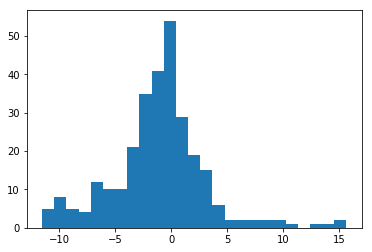

In [21]:
r_a1=rezidua(data1,W_a1) # do proměnné "r_a" uložíme hodnoty expvalue a sigma3

Vidíme, že šikmost i špičatost se od nuly liší o méně než $2\sigma$, tudíž nulovou hypotézu, že rezidua mají normální rozdělení, nemůžeme zamítnout. Rezidua tedy odpovídají normálně rozděleným datům.

### b) Rozptyl úměrný naměřeným hodnotám

V případě b), kdy je rozptyl úměrný naměřeným hodnotám, bude po transformaci platit úměra $\sigma^2 \approx y^{-1}$. Na diagonále váhové matice se tedy budou nacházet hodnoty $y$.

ln(A) = 4.504558290297545 +- 0.007271980941321642
korel.koef. = 0.7358714376794838
Q_min= 45.4730240108633
A = 90.4283921277629 +- 0.6575935441074519
L = 0.45433483609366054 +- 0.0027031023008878986


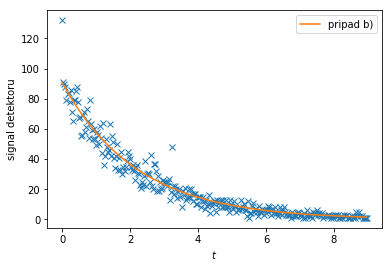

In [22]:
W_b=np.eye(len(x))*(y)
title_b="pripad b)"
b=analyza(data, W_b, title_b)

skew = 2.1313234669615806 +- 0.1426148065624585
kurt = 15.326658180133009 +- 0.285229613124917
2sigma = 10.675018291482376 
3sigma = 16.012527437223564 


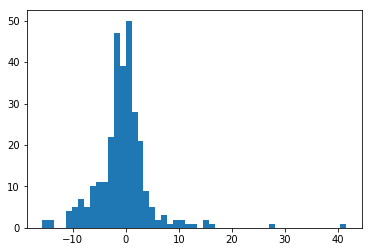

In [23]:
r_b=rezidua(data,W_b)

Opět vidíme, že rozdělení rezudií není normální, proto odděláme odlehlé hodnoty.

In [24]:
pole_b1 = []
for z in pole:
   if (r_b[0]-r_b[1]) < (z[1] -(b[0]*np.exp(-z[0]*b[1]))) < r_b[0]+r_b[1]:
        pole_b1.append(z)
pole_b1 = np.array(pole_b1)
x2,y2=data2=np.transpose(pole_b1)

ln(A) = 4.47948977477985 +- 0.007448733794281786
korel.koef. = 0.7426812855700488
Q_min= 44.31615345217824
A = 88.18966460346387 +- 0.6569013350381976
L = 0.45069001937841313 +- 0.002728624510593743


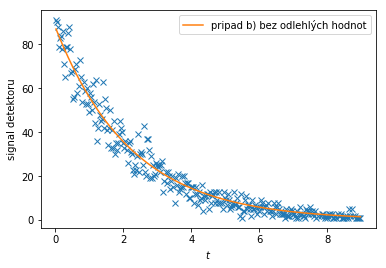

In [25]:
W_b1=np.eye(len(x2))*(y2)
title_b1="pripad b) bez odlehlých hodnot"
b1=analyza(data2, W_b1, title_b1)

skew = 0.304628577570488 +- 0.14334554477024897
kurt = 2.399426489469051 +- 0.28669108954049793
2sigma = 8.676805472612967 
3sigma = 13.01520820891945 


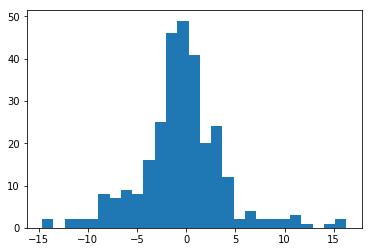

In [26]:
r_b1=rezidua(data2,W_b1)

Nyní již jsou šikmost i špičatost měnší než $2\sigma$, tudíž jsme ověřili, že i v tomto případě mají rezidua normální rozdělení.

Pro zajímavost můžeme nakonec vykreslit všechny tři případy, tj. výpočet bez váhové matice, případ a) a b) (oba bez odlehlých hodnot).

ln(A) = 4.509360443028548 +- 0.0011298384142490972
korel.koef. = 0.7156923771919719
Q_min= 49.14578134568504
A = 90.86368741869804 +- 0.10266128450596744
L = 0.4448481406870539 +- 0.0007175048418888641
ln(A) = 4.47948977477985 +- 0.007448733794281786
korel.koef. = 0.7426812855700488
Q_min= 44.31615345217824
A = 88.18966460346387 +- 0.6569013350381976
L = 0.45069001937841313 +- 0.002728624510593743


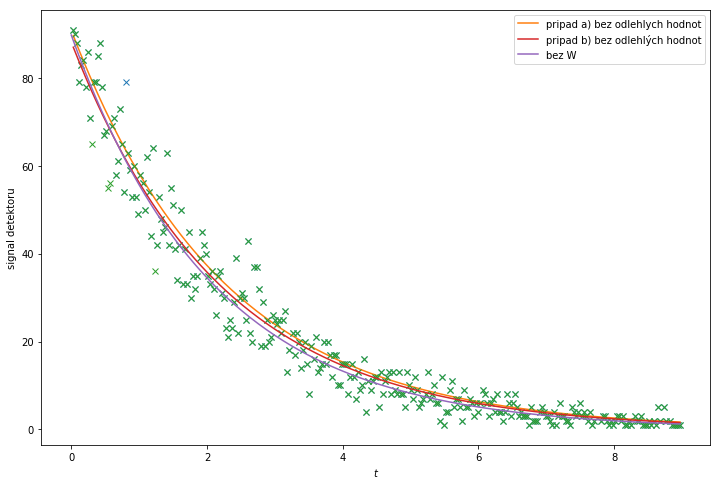

In [30]:
a1=analyza(data1, W_a1, title_a1)
b1=analyza(data2, W_b1, title_b1)
plt.plot(x,A*np.exp(-x*L), label="bez W")
plt.legend(loc=0)
plt.rcParams['figure.figsize'] = 12, 8